#**Melanoma Detection Project**

**Problem Statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma and the solution has potential to reduce a lot of manual effort needed in diagnosis.

**Objectives of Analysis:**

The goal of the project is to build a CNN based model which can evaluate images and alert the dermatologists about the presence of melanoma. Considering the input data provided, the CNN model is to take into account underfitting/overfitting, class imbalance and data augmentation strategy and hyperparameters tuning.

- Data understanding
- Data creation
- Data visualization
- Model building & training
- Data augmentation
- Model building & training on augmented data
- Handling class imbalances
- Model building & training on the rectified class imbalance data


**Input Data:**

Data are provided in the folder "Skin cancer ISIC The International Skin Imaging Collaboration" which contains train and test images. The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC. All images were sorted according to the classification taken with ISIC.
The data set contains the following diseases:

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion

**Data Understanding**

Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

In [ ]:
#Mounting the google drive :
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
# Checking train and test files
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Data Creation**

In [ ]:
# Defining some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Splitting data -  80% of the images for training and 20% for validation.

In [ ]:
# Using seed=123 while creating training dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
            validation_split=0.2, subset = "training", seed = 123,
            image_size = (img_height, img_width), batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Using seed=123 while creating validation dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
            validation_split=0.2, subset = "validation", seed = 123,
            image_size = (img_height, img_width), batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list. 
# The class names are in the class_names attribute on these datasets. 
class_names = train_ds.class_names
print(class_names)
# Checking number class names
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


**Data Visualization**

Found 2239 files belonging to 9 classes.


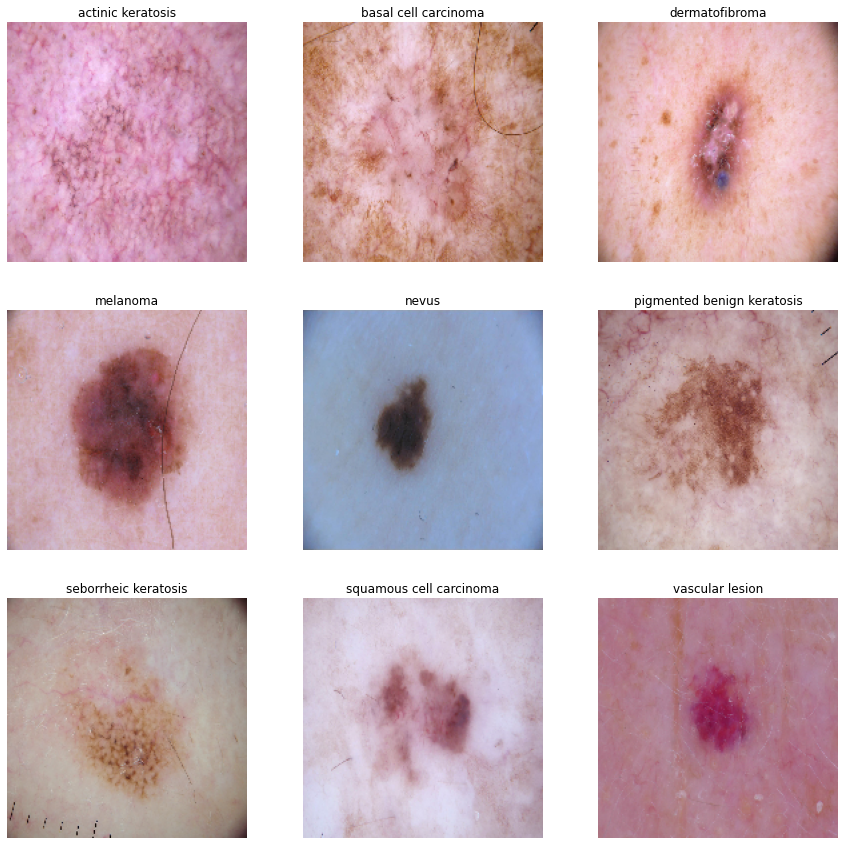

In [ ]:
# coding to visualize data of all the nine classes present in the dataset
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                batch_size=batch_size, image_size=(img_height,img_width),
                label_mode = 'categorical', seed = 123)
#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [ ]:
# Showing number of images in each class
def class_distribution_count(directory):
    
    #counting number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #class names
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

class_df = class_distribution_count(data_dir_train)
class_df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,melanoma,438
3,pigmented benign keratosis,462
4,seborrheic keratosis,77
5,nevus,357
6,dermatofibroma,95
7,squamous cell carcinoma,181
8,vascular lesion,139


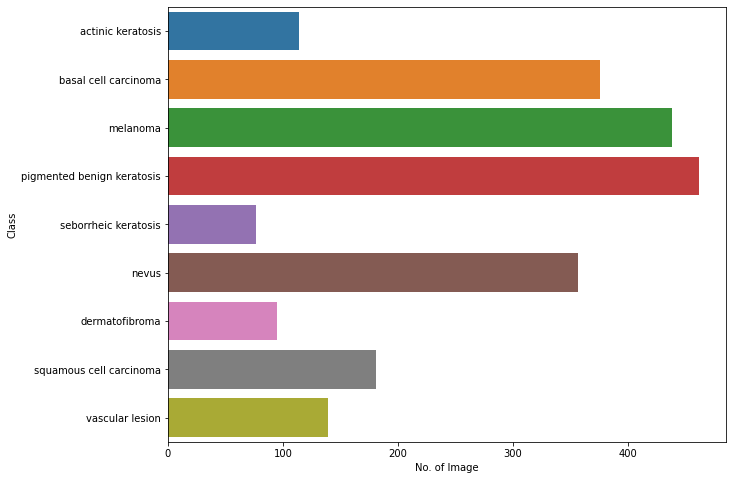

In [ ]:
# Showming number of images in bar chart
import seaborn as sns
plt.figure(figsize=(10,8))
sns.barplot(x="No. of Image", y="Class", data=class_df, label="Class")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Model building and training**

Creating a CNN model to detect 9 classes present in the dataset.
Using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# Setting up First model architecture


model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = (180, 180, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))


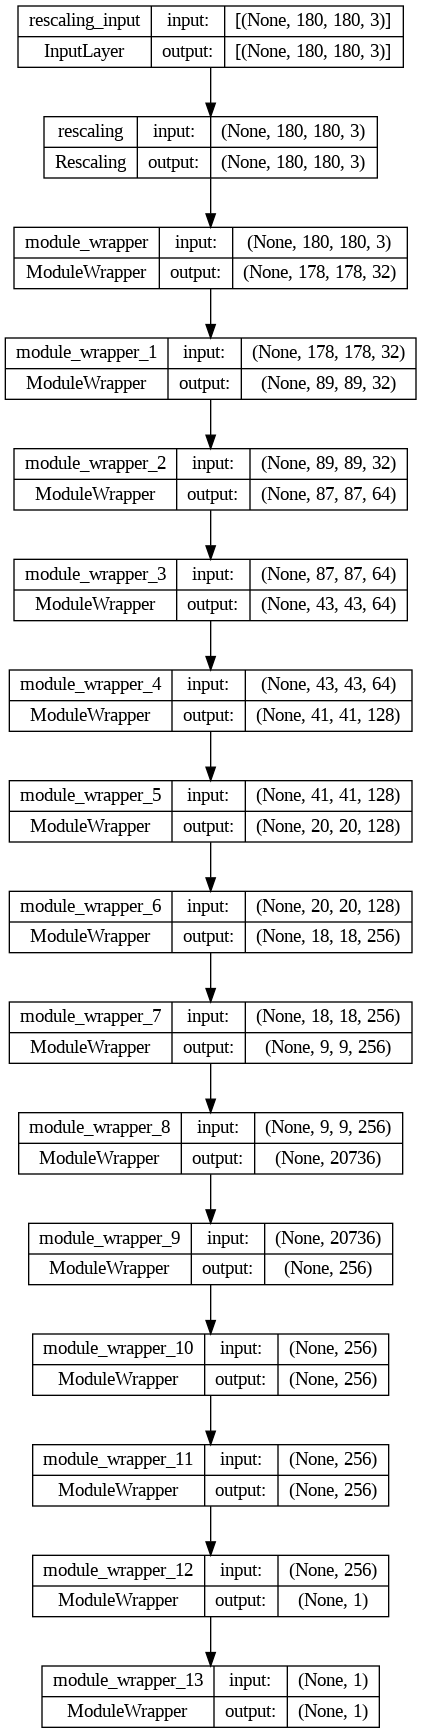

In [ ]:
# Visualizing the model architecture
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names=True)

**Model compliation**

Appropriate optimiser and loss function are considered for model training 

In [ ]:
# Choosing appropriate optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 89, 89, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 87, 87, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 43, 43, 64)       0         
 pper)                                                  

**Training the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 545s 2s/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - v

**Visualizing training results**

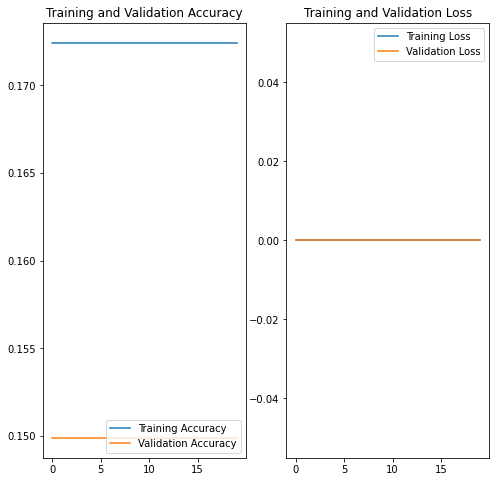

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analysis result finding**

Training accuracy is 0.17 and validation accuracy is 0.15 which are significantly less. it shows that the model is not fitting well on the data (underfitting).

Number of images in a few classes such as 'seborrheic keratosis' and 'dermatofibroma' are less compared to other classes.	

**Data Augmentation**

In [ ]:
# After analysing the model fit above, it is understood that the model is not fitting well. Because it, the accuracy is poor. Lets consider ImageDataGenerator for new variants of images as part data augumentation strategy. 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


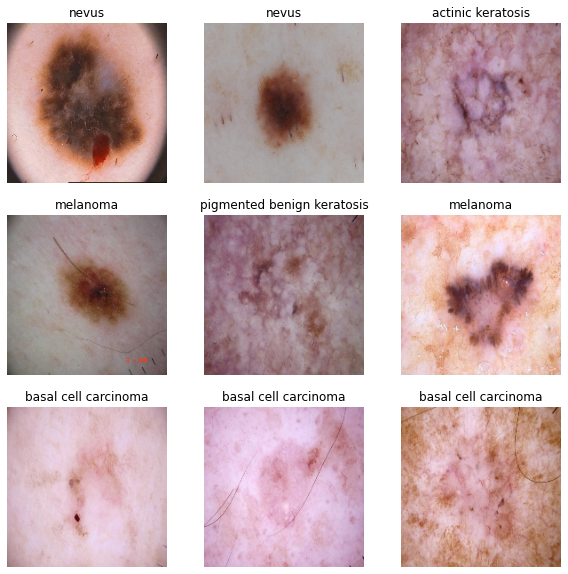

In [ ]:
# visualizing how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Setting up Second model architecture
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', padding='same', input_shape = (180, 180, 3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', padding='same', input_shape = (180, 180, 3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))

In [ ]:
# Viewing the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_14 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_16 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_17 (ModuleWr  (None, 90, 90, 64)       18496     
 apper)                                               

In [ ]:
# Choosing appropriate optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
# Training the model
epochs = 20
history = model.fit(  train_ds,  validation_data=val_ds,  epochs=epochs)

Epoch 1/20
56/56 [==============================] - 4s 52ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 3s 52ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - v

From the above result, it is understood that there is no noticeable improvement in accuracy after using ImageDataGenerator for new variants of images.

As the number of images are less in some of the catagories, data augmentation to increase number of images in each category might help and improve performance of the result. This can avoid class imbalance.

**Handing Class Imbalance**

In [ ]:
# installing Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(image_count_train)

2239


In [ ]:
path_to_training_dataset = "/content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) #adding 500 sample per class

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0FA739100>: 100%|██████████| 500/500 [00:24<00:00, 20.78 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0FA7007F0>: 100%|██████████| 500/500 [00:18<00:00, 27.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC1FC3E70A0>: 100%|██████████| 500/500 [00:18<00:00, 27.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC0FA710190>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=960x645 at 0x7FC0FA75E430>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0FA6CACD0>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC1068C8820>: 100%|██████████| 500/500 [00:40<00:00, 12.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0FA713070>: 100%|██████████| 500/500 [00:17<00:00, 28.22 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC106126D30>: 100%|██████████| 500/500 [00:17<00:00, 27.78 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


After adding additional imagaes to the original train data by means of  data augmentation, lets see the distribution of augmented data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list
path_list_new = path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
lesion_list =[]
path_list = []
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()), columns = ['path','Label'])
original_df

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

We have added 500 images to all the classes to maintain class balance. we can add more images as we want to improve the training process.

**Model building & training on augmented data**


Training the data on the data created using aumentation

batch_size = 32

img_height = 180

img_width = 180

In [ ]:
#new train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
            validation_split=0.2,subset = "training", seed = 123,
            image_size = (img_height, img_width), batch_size = batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
#new test dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
            validation_split=0.2, subset = "validation", seed = 123,
            image_size = (img_height, img_width), batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# tf.data.experimental.AUTOTUNE defines appropriate number of process
# Dataset.cache() to keep images in memory after they are loaded off disk during first epoch
# Dataset.prefetch() overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# New CNN model architecture (Third model)
model = Sequential()

# Creating models layer by layer
model.add(layers.experimental.preprocessing.Rescaling (1./255, input_shape=(180,180,3)))

#Layer 1 with 32 kernels
model.add(layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Layer 2 with 64 kernels
model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Layer 3 with 128 kernels
model.add(layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Layer dropout with 50% fraction of input
model.add(layers.Dropout(0.5))

#Layer flatten
model.add(layers.Flatten())

#Dense layer 1
model.add(layers.Dense(128, activation='relu'))

#Layer dropout with 25% fraction of input
model.add(layers.Dropout(0.25))

#Dense layer 2 with softmax function
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 89, 89, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 43, 43, 64)      

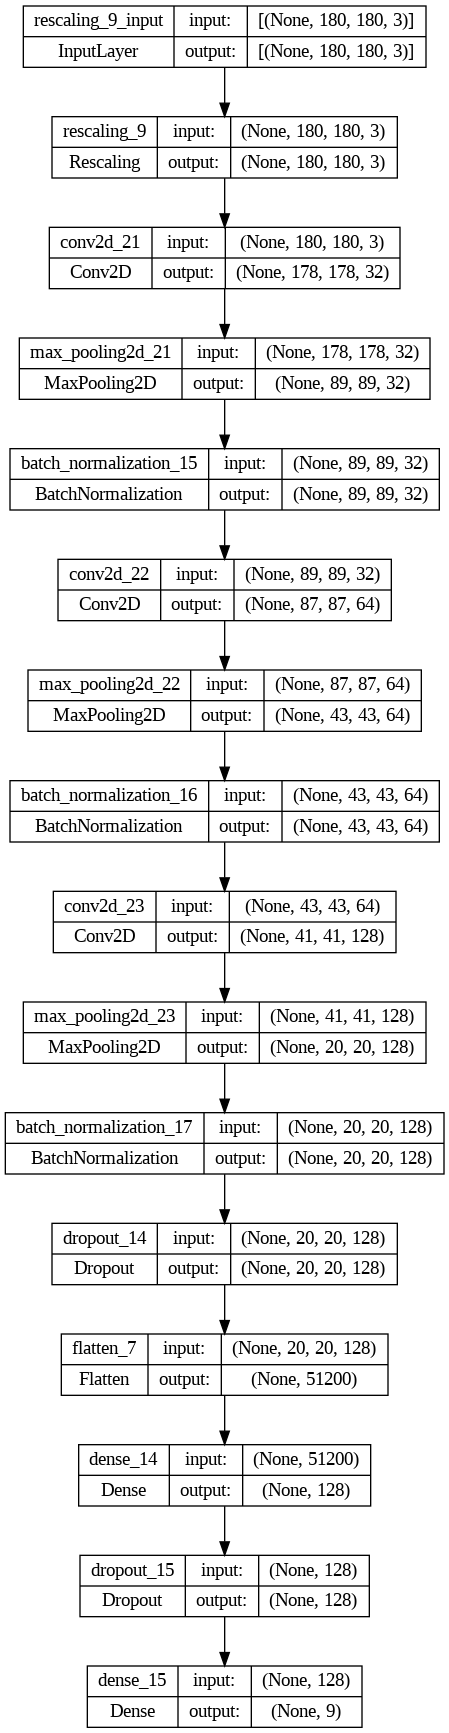

In [ ]:
# Visualizing the model architecture
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names=True)

**Model compilation**

In [ ]:
# Choosing appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


**Training the new model**

In [ ]:
# Train your model for 30 epochs as per starter code

epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 8s 41ms/step - loss: 5.0394 - accuracy: 0.3038 - val_loss: 14.9741 - val_accuracy: 0.1166
Epoch 2/30
169/169 [==============================] - 7s 40ms/step - loss: 2.5362 - accuracy: 0.3444 - val_loss: 7.2323 - val_accuracy: 0.2153
Epoch 3/30
169/169 [==============================] - 7s 40ms/step - loss: 1.8178 - accuracy: 0.4182 - val_loss: 2.2057 - val_accuracy: 0.4276
Epoch 4/30
169/169 [==============================] - 7s 40ms/step - loss: 1.4784 - accuracy: 0.4848 - val_loss: 1.9083 - val_accuracy: 0.4276
Epoch 5/30
169/169 [==============================] - 7s 40ms/step - loss: 1.3209 - accuracy: 0.5230 - val_loss: 1.9119 - val_accuracy: 0.4929
Epoch 6/30
169/169 [==============================] - 7s 40ms/step - loss: 1.0995 - accuracy: 0.5914 - val_loss: 1.8587 - val_accuracy: 0.4610
Epoch 7/30
169/169 [==============================] - 7s 40ms/step - loss: 1.0283 - accuracy: 0.6089 - val_loss: 1.1787 - val_accuracy: 0.602

**Visualizing the training results after data augmentation**

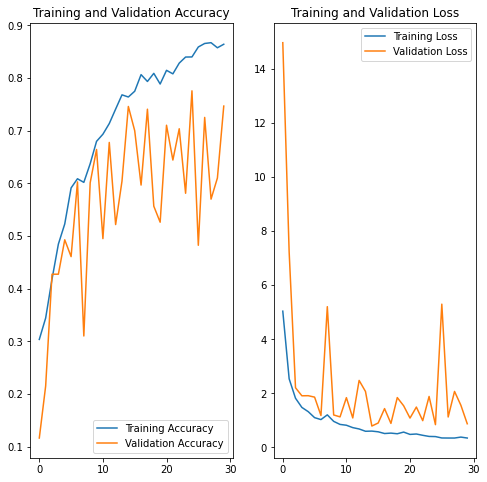

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above result, it is understood that data augmentation for class balancing helped significantly to improve the prodiction result in both training and validation results. However, overfitting is observed as validation accuracy is less and also validation accuracy is fluctuating significantly due to change in epochs size.

Lets train the model without batchnormalization to check whether overfitting can be controlled

**Model building & training on rectified class augmented data**

In [ ]:
model = Sequential()

# Creating models layer by layer
model.add(layers.experimental.preprocessing.Rescaling (1./255, input_shape=(180,180,3)))

#Layer 1 with 32 kernels
model.add(layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Layer 2 with 64 kernels
model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Layer 3 with 128 kernels
model.add(layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Layer dropout with 50% fraction of input
model.add(layers.Dropout(0.5))

#Layer flatten
model.add(layers.Flatten())

#Dense layer 1
model.add(layers.Dense(128, activation='relu'))

#Layer dropout with 25% fraction of input
model.add(layers.Dropout(0.25))

#Dense layer 2 with softmax function
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)      

In [ ]:
# Choosing appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Train your model for 30 epochs without Batchnormalization

epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 7s 40ms/step - loss: 1.9560 - accuracy: 0.2355 - val_loss: 1.8396 - val_accuracy: 0.2866
Epoch 2/30
169/169 [==============================] - 7s 40ms/step - loss: 1.5692 - accuracy: 0.4023 - val_loss: 1.3900 - val_accuracy: 0.4729
Epoch 3/30
169/169 [==============================] - 7s 39ms/step - loss: 1.3966 - accuracy: 0.4705 - val_loss: 1.2555 - val_accuracy: 0.5182
Epoch 4/30
169/169 [==============================] - 7s 39ms/step - loss: 1.2973 - accuracy: 0.5045 - val_loss: 1.1411 - val_accuracy: 0.5731
Epoch 5/30
169/169 [==============================] - 7s 39ms/step - loss: 1.2047 - accuracy: 0.5484 - val_loss: 1.1031 - val_accuracy: 0.5895
Epoch 6/30
169/169 [==============================] - 7s 39ms/step - loss: 1.1069 - accuracy: 0.5892 - val_loss: 0.9693 - val_accuracy: 0.6251
Epoch 7/30
169/169 [==============================] - 7s 41ms/step - loss: 0.9806 - accuracy: 0.6382 - val_loss: 0.8957 - val_accuracy: 0.6607

**Visualizing the training results after data augmentation**

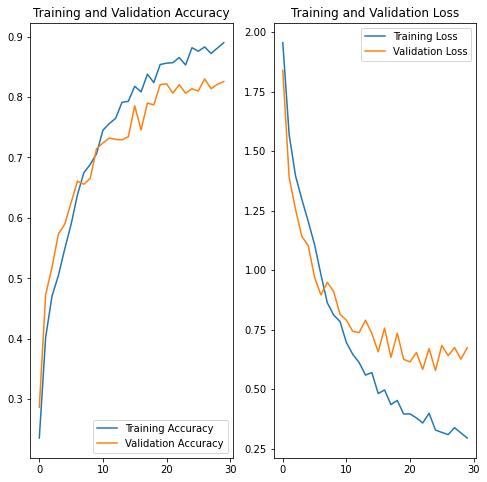

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above result, it is understood that data augmentation for class imbalancing without batch normalization helped significantly to improve the prediction result in both training and validation results. Also, overfitting is controlled significantly as the different between training and validation accuracy is less.

**Model prediction on Test data**

1/1 [==============================] - 0s 65ms/step
Actual Class dermatofibroma
Predictive Class dermatofibroma


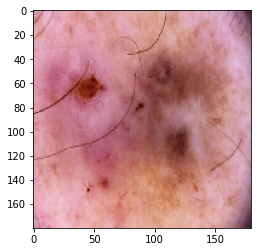

In [ ]:
Test_image_path = os.path.join(data_dir_test, class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[2] +'\n'+ "Predictive Class "+pred_class )